In [25]:
import pandas as pd
import os
import time
import requests
import pyarrow.parquet as pq
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm

# ======================================================================
# 1. CONFIGURATION
# ======================================================================

CROSSWALK_FILE = "output/nyc_zone_tract_crosswalk.csv"
OUTPUT_DIR = "output"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "OD_demand_TLC.csv")

total_bytes_downloaded = 0

COLUMNS_TO_LOAD = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_distance",
    "passenger_count",
    "total_amount",
    "PULocationID",
    "DOLocationID",
]

MIN_DISTANCE_MILES = 2.0
MIN_DURATION_MINUTES = 5.0
MAX_DURATION_MINUTES = 240
MIN_PASSENGERS = 1
MIN_FARE = 2.5
VALID_ZONE_RANGE = (1, 263)

HEADERS = {
    "User-Agent": "Mozilla/5.0",
    "Connection": "keep-alive",
}

# ======================================================================
# 2. HELPERS
# ======================================================================

def get_file_size_head(url):
    """Accurate size using HEAD request."""
    try:
        r = requests.head(url, headers=HEADERS, timeout=10)
        if "Content-Length" in r.headers:
            return int(r.headers["Content-Length"])
    except:
        pass
    return None


def stream_parquet_in_chunks(url):
    """
    Downloads the full parquet and yields each row group.
    """
    global total_bytes_downloaded

    response = requests.get(url, headers=HEADERS, stream=True, timeout=60)
    response.raise_for_status()

    content = BytesIO(response.content)
    total_bytes_downloaded += len(response.content)

    parquet_file = pq.ParquetFile(content)

    for rg in range(parquet_file.num_row_groups):
        yield parquet_file.read_row_group(rg, columns=COLUMNS_TO_LOAD).to_pandas()


# ======================================================================
# 3. URL LIST
# ======================================================================

print("➡️ Step 1: Generating data URLs...")
dates = pd.date_range("2020-01-01", "2024-12-01", freq="MS")

TLC_URLS = [
    f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{d.strftime('%Y-%m')}.parquet"
    for d in dates
]

print(f"Generated {len(TLC_URLS)} URLs")
print("-" * 50)

# ======================================================================
# 4. LOAD CROSSWALK
# ======================================================================

print(f"Step 2: Loading crosswalk '{CROSSWALK_FILE}'...")
df_crosswalk = pd.read_csv(CROSSWALK_FILE)

pickup_crosswalk = df_crosswalk.rename(columns={
    "LocationID": "PULocationID",
    "census_tract_id": "pickup_tract_id",
    "apportion_weight": "pickup_weight",
})

dropoff_crosswalk = df_crosswalk.rename(columns={
    "LocationID": "DOLocationID",
    "census_tract_id": "dropoff_tract_id",
    "apportion_weight": "dropoff_weight",
})

print("Crosswalk loaded")
print("-" * 50)

# ======================================================================
# 5. PROCESS MONTH-BY-MONTH (NOW WITH TQDM BAR)
# ======================================================================

print(f"Step 3: Processing {len(TLC_URLS)} monthly files...\n")

all_months = []
global_start = time.time()

for i, url in enumerate(tqdm(TLC_URLS, desc="Monthly Files Processed")):
    label = url.split("/")[-1]
    print(f"\n  ({i+1}/{len(TLC_URLS)}) {label}")
    month_start = time.time()

    # -------- 1. Get size via HEAD --------
    size = get_file_size_head(url)
    if size:
        print(f"       File size: {size / (1024**3):.3f} GB")
    else:
        print("       File size: Unknown (HEAD failed)")

    od_chunks = []

    # -------- 2. Stream row-groups --------
    try:
        for chunk_df in stream_parquet_in_chunks(url):

            chunk_df["tpep_pickup_datetime"] = pd.to_datetime(
                chunk_df["tpep_pickup_datetime"], errors="coerce")
            chunk_df["tpep_dropoff_datetime"] = pd.to_datetime(
                chunk_df["tpep_dropoff_datetime"], errors="coerce")

            chunk_df["duration_min"] = (
                chunk_df["tpep_dropoff_datetime"] - chunk_df["tpep_pickup_datetime"]
            ).dt.total_seconds() / 60

            df_filtered = chunk_df[
                (chunk_df["passenger_count"] >= MIN_PASSENGERS) &
                (chunk_df["total_amount"] > MIN_FARE) &
                (chunk_df["PULocationID"] != chunk_df["DOLocationID"]) &
                (chunk_df["PULocationID"].between(*VALID_ZONE_RANGE)) &
                (chunk_df["DOLocationID"].between(*VALID_ZONE_RANGE)) &
                (chunk_df["trip_distance"] > MIN_DISTANCE_MILES) &
                (chunk_df["duration_min"].between(MIN_DURATION_MINUTES, MAX_DURATION_MINUTES))
            ][["PULocationID", "DOLocationID"]]

            if df_filtered.empty:
                continue

            merged = df_filtered.merge(pickup_crosswalk, on="PULocationID", how="inner")
            merged = merged.merge(dropoff_crosswalk, on="DOLocationID", how="inner")

            merged["trip_fraction"] = merged["pickup_weight"] * merged["dropoff_weight"]

            od_chunks.append(
                merged.groupby(["pickup_tract_id", "dropoff_tract_id"])["trip_fraction"]
                .sum()
                .reset_index()
            )

        if od_chunks:
            month_df = pd.concat(od_chunks)
            all_months.append(month_df)
            print(f"       ✔ Completed month: {len(month_df)} OD pairs")
        else:
            print("       ✔ Completed month: (no qualifying trips)")

    except Exception as e:
        print(f"      Error processing: {e}")

    # ----- Month time summary -----
    month_end = time.time()
    print(f"       Time: {(month_end - month_start):.1f} sec")

# ======================================================================
# 6. FINAL OD AGGREGATION
# ======================================================================

print("\nStep 4: Combining all months...")

if not all_months:
    print("No months were processed successfully.")
else:
    df_all = pd.concat(all_months)

    final = (
        df_all.groupby(["pickup_tract_id", "dropoff_tract_id"])["trip_fraction"]
        .sum()
        .reset_index()
    )

    final.rename(columns={"trip_fraction": "total_trips"}, inplace=True)
    final["total_trips"] = final["total_trips"].round(4)

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    final.to_csv(OUTPUT_FILE, index=False)

    print(f"Saved final OD matrix → {OUTPUT_FILE}\n")
    print(final.sort_values("total_trips", ascending=False).head(10))

# ======================================================================
# 7. SUMMARY
# ======================================================================

print("======================================================")
print(f"TOTAL BYTES DOWNLOADED: {total_bytes_downloaded / (1024**3):.3f} GB")
print(f"TOTAL TIME: {(time.time() - global_start)/60:.1f} min")
print("======================================================")


➡️ Step 1: Generating data URLs...
Generated 60 URLs
--------------------------------------------------
Step 2: Loading crosswalk 'output/nyc_zone_tract_crosswalk.csv'...
Crosswalk loaded
--------------------------------------------------
Step 3: Processing 60 monthly files...



Monthly Files Processed:   0%|                                                                                          | 0/60 [00:00<?, ?it/s]


  (1/60) yellow_tripdata_2020-01.parquet
       File size: 0.087 GB


Monthly Files Processed:   2%|█▎                                                                              | 1/60 [01:20<1:18:40, 80.01s/it]

       ✔ Completed month: 1668750 OD pairs
       Time: 80.0 sec

  (2/60) yellow_tripdata_2020-02.parquet
       File size: 0.086 GB


Monthly Files Processed:   3%|██▋                                                                               | 2/60 [02:06<58:32, 60.55s/it]

       ✔ Completed month: 1610506 OD pairs
       Time: 46.9 sec

  (3/60) yellow_tripdata_2020-03.parquet
       File size: 0.041 GB


Monthly Files Processed:   5%|████                                                                              | 3/60 [02:31<41:54, 44.12s/it]

       ✔ Completed month: 1417730 OD pairs
       Time: 24.6 sec

  (4/60) yellow_tripdata_2020-04.parquet
       File size: 0.004 GB


Monthly Files Processed:   7%|█████▍                                                                            | 4/60 [02:33<25:39, 27.50s/it]

       ✔ Completed month: 634744 OD pairs
       Time: 2.0 sec

  (5/60) yellow_tripdata_2020-05.parquet
       File size: 0.006 GB


Monthly Files Processed:   8%|██████▊                                                                           | 5/60 [02:36<16:56, 18.49s/it]

       ✔ Completed month: 782607 OD pairs
       Time: 2.5 sec

  (6/60) yellow_tripdata_2020-06.parquet
       File size: 0.009 GB


Monthly Files Processed:  10%|████████▏                                                                         | 6/60 [02:40<12:16, 13.64s/it]

       ✔ Completed month: 935840 OD pairs
       Time: 4.2 sec

  (7/60) yellow_tripdata_2020-07.parquet
       File size: 0.012 GB


Monthly Files Processed:  12%|█████████▌                                                                        | 7/60 [02:45<09:39, 10.94s/it]

       ✔ Completed month: 971663 OD pairs
       Time: 5.4 sec

  (8/60) yellow_tripdata_2020-08.parquet
       File size: 0.015 GB


Monthly Files Processed:  13%|██████████▉                                                                       | 8/60 [02:51<08:11,  9.46s/it]

       ✔ Completed month: 1029008 OD pairs
       Time: 6.3 sec

  (9/60) yellow_tripdata_2020-09.parquet
       File size: 0.020 GB


Monthly Files Processed:  15%|████████████▎                                                                     | 9/60 [02:59<07:29,  8.81s/it]

       ✔ Completed month: 1053633 OD pairs
       Time: 7.4 sec

  (10/60) yellow_tripdata_2020-10.parquet
       File size: 0.025 GB


Monthly Files Processed:  17%|█████████████▌                                                                   | 10/60 [03:09<07:35,  9.11s/it]

       ✔ Completed month: 1069355 OD pairs
       Time: 9.8 sec

  (11/60) yellow_tripdata_2020-11.parquet
       File size: 0.022 GB


Monthly Files Processed:  18%|██████████████▊                                                                  | 11/60 [03:15<06:49,  8.35s/it]

       ✔ Completed month: 993269 OD pairs
       Time: 6.6 sec

  (12/60) yellow_tripdata_2020-12.parquet
       File size: 0.021 GB


Monthly Files Processed:  20%|████████████████▏                                                                | 12/60 [03:22<06:19,  7.91s/it]

       ✔ Completed month: 985506 OD pairs
       Time: 6.9 sec

  (13/60) yellow_tripdata_2021-01.parquet
       File size: 0.020 GB


Monthly Files Processed:  22%|█████████████████▌                                                               | 13/60 [03:28<05:48,  7.42s/it]

       ✔ Completed month: 959278 OD pairs
       Time: 6.3 sec

  (14/60) yellow_tripdata_2021-02.parquet
       File size: 0.020 GB


Monthly Files Processed:  23%|██████████████████▉                                                              | 14/60 [03:35<05:28,  7.13s/it]

       ✔ Completed month: 1118117 OD pairs
       Time: 6.5 sec

  (15/60) yellow_tripdata_2021-03.parquet
       File size: 0.028 GB


Monthly Files Processed:  25%|████████████████████▎                                                            | 15/60 [03:47<06:31,  8.70s/it]

       ✔ Completed month: 1115680 OD pairs
       Time: 12.3 sec

  (16/60) yellow_tripdata_2021-04.parquet
       File size: 0.032 GB


Monthly Files Processed:  27%|█████████████████████▌                                                           | 16/60 [04:00<07:12,  9.84s/it]

       ✔ Completed month: 1127487 OD pairs
       Time: 12.5 sec

  (17/60) yellow_tripdata_2021-05.parquet
       File size: 0.036 GB


Monthly Files Processed:  28%|██████████████████████▉                                                          | 17/60 [04:19<09:04, 12.66s/it]

       ✔ Completed month: 1132749 OD pairs
       Time: 19.2 sec

  (18/60) yellow_tripdata_2021-06.parquet
       File size: 0.041 GB


Monthly Files Processed:  30%|████████████████████████▎                                                        | 18/60 [04:38<10:08, 14.49s/it]

       ✔ Completed month: 1164803 OD pairs
       Time: 18.7 sec

  (19/60) yellow_tripdata_2021-07.parquet
       File size: 0.041 GB


Monthly Files Processed:  32%|█████████████████████████▋                                                       | 19/60 [04:55<10:34, 15.47s/it]

       ✔ Completed month: 1159855 OD pairs
       Time: 17.8 sec

  (20/60) yellow_tripdata_2021-08.parquet
       File size: 0.040 GB


Monthly Files Processed:  33%|███████████████████████████                                                      | 20/60 [05:11<10:23, 15.59s/it]

       ✔ Completed month: 1213896 OD pairs
       Time: 15.9 sec

  (21/60) yellow_tripdata_2021-09.parquet
       File size: 0.043 GB


Monthly Files Processed:  35%|████████████████████████████▎                                                    | 21/60 [05:30<10:41, 16.46s/it]

       ✔ Completed month: 1299489 OD pairs
       Time: 18.5 sec

  (22/60) yellow_tripdata_2021-10.parquet
       File size: 0.050 GB


Monthly Files Processed:  37%|█████████████████████████████▋                                                   | 22/60 [05:51<11:17, 17.84s/it]

       ✔ Completed month: 1296076 OD pairs
       Time: 21.1 sec

  (23/60) yellow_tripdata_2021-11.parquet
       File size: 0.049 GB


Monthly Files Processed:  38%|███████████████████████████████                                                  | 23/60 [06:13<11:51, 19.22s/it]

       ✔ Completed month: 1291722 OD pairs
       Time: 22.4 sec

  (24/60) yellow_tripdata_2021-12.parquet
       File size: 0.046 GB


Monthly Files Processed:  40%|████████████████████████████████▍                                                | 24/60 [06:39<12:44, 21.22s/it]

       ✔ Completed month: 1325120 OD pairs
       Time: 25.9 sec

  (25/60) yellow_tripdata_2022-01.parquet
       File size: 0.036 GB


Monthly Files Processed:  42%|█████████████████████████████████▊                                               | 25/60 [06:53<11:06, 19.05s/it]

       ✔ Completed month: 1348296 OD pairs
       Time: 14.0 sec

  (26/60) yellow_tripdata_2022-02.parquet
       File size: 0.042 GB


Monthly Files Processed:  43%|███████████████████████████████████                                              | 26/60 [07:28<13:30, 23.85s/it]

       ✔ Completed month: 1471188 OD pairs
       Time: 35.0 sec

  (27/60) yellow_tripdata_2022-03.parquet
       File size: 0.052 GB


Monthly Files Processed:  45%|████████████████████████████████████▍                                            | 27/60 [08:00<14:25, 26.23s/it]

       ✔ Completed month: 1541531 OD pairs
       Time: 31.8 sec

  (28/60) yellow_tripdata_2022-04.parquet
       File size: 0.051 GB


Monthly Files Processed:  47%|█████████████████████████████████████▊                                           | 28/60 [08:38<15:54, 29.82s/it]

       ✔ Completed month: 1525888 OD pairs
       Time: 38.2 sec

  (29/60) yellow_tripdata_2022-05.parquet
       File size: 0.052 GB


Monthly Files Processed:  48%|███████████████████████████████████████▏                                         | 29/60 [09:10<15:41, 30.37s/it]

       ✔ Completed month: 1494423 OD pairs
       Time: 31.7 sec

  (30/60) yellow_tripdata_2022-06.parquet
       File size: 0.052 GB


Monthly Files Processed:  50%|████████████████████████████████████████▌                                        | 30/60 [09:45<15:55, 31.85s/it]

       ✔ Completed month: 1564166 OD pairs
       Time: 35.3 sec

  (31/60) yellow_tripdata_2022-07.parquet
       File size: 0.046 GB


Monthly Files Processed:  52%|█████████████████████████████████████████▊                                       | 31/60 [10:24<16:25, 33.98s/it]

       ✔ Completed month: 1519939 OD pairs
       Time: 38.9 sec

  (32/60) yellow_tripdata_2022-08.parquet
       File size: 0.046 GB


Monthly Files Processed:  53%|███████████████████████████████████████████▏                                     | 32/60 [10:57<15:39, 33.57s/it]

       ✔ Completed month: 1551865 OD pairs
       Time: 32.6 sec

  (33/60) yellow_tripdata_2022-09.parquet
       File size: 0.046 GB


Monthly Files Processed:  55%|████████████████████████████████████████████▌                                    | 33/60 [11:33<15:27, 34.35s/it]

       ✔ Completed month: 1565702 OD pairs
       Time: 36.2 sec

  (34/60) yellow_tripdata_2022-10.parquet
       File size: 0.053 GB


Monthly Files Processed:  57%|█████████████████████████████████████████████▉                                   | 34/60 [12:37<18:47, 43.35s/it]

       ✔ Completed month: 1555547 OD pairs
       Time: 64.4 sec

  (35/60) yellow_tripdata_2022-11.parquet
       File size: 0.047 GB


Monthly Files Processed:  58%|███████████████████████████████████████████████▎                                 | 35/60 [13:16<17:30, 42.01s/it]

       ✔ Completed month: 1392616 OD pairs
       Time: 38.9 sec

  (36/60) yellow_tripdata_2022-12.parquet
       File size: 0.050 GB


Monthly Files Processed:  60%|████████████████████████████████████████████████▌                                | 36/60 [13:47<15:31, 38.82s/it]

       ✔ Completed month: 1567639 OD pairs
       Time: 31.4 sec

  (37/60) yellow_tripdata_2023-01.parquet
       File size: 0.044 GB


Monthly Files Processed:  62%|█████████████████████████████████████████████████▉                               | 37/60 [14:15<13:31, 35.29s/it]

       ✔ Completed month: 1582204 OD pairs
       Time: 27.0 sec

  (38/60) yellow_tripdata_2023-02.parquet
       File size: 0.044 GB


Monthly Files Processed:  63%|███████████████████████████████████████████████████▎                             | 38/60 [14:31<10:50, 29.56s/it]

       ✔ Completed month: 1523718 OD pairs
       Time: 16.2 sec

  (39/60) yellow_tripdata_2023-03.parquet
       File size: 0.052 GB


Monthly Files Processed:  65%|████████████████████████████████████████████████████▋                            | 39/60 [14:51<09:21, 26.73s/it]

       ✔ Completed month: 1701461 OD pairs
       Time: 20.1 sec

  (40/60) yellow_tripdata_2023-04.parquet
       File size: 0.050 GB


Monthly Files Processed:  67%|██████████████████████████████████████████████████████                           | 40/60 [15:18<08:58, 26.90s/it]

       ✔ Completed month: 1704014 OD pairs
       Time: 27.3 sec

  (41/60) yellow_tripdata_2023-05.parquet
       File size: 0.055 GB


Monthly Files Processed:  68%|███████████████████████████████████████████████████████▎                         | 41/60 [15:35<07:31, 23.78s/it]

       ✔ Completed month: 1736608 OD pairs
       Time: 16.5 sec

  (42/60) yellow_tripdata_2023-06.parquet
       File size: 0.051 GB


Monthly Files Processed:  70%|████████████████████████████████████████████████████████▋                        | 42/60 [15:55<06:47, 22.63s/it]

       ✔ Completed month: 1690135 OD pairs
       Time: 19.9 sec

  (43/60) yellow_tripdata_2023-07.parquet
       File size: 0.045 GB


Monthly Files Processed:  72%|██████████████████████████████████████████████████████████                       | 43/60 [16:10<05:49, 20.55s/it]

       ✔ Completed month: 1647555 OD pairs
       Time: 15.7 sec

  (44/60) yellow_tripdata_2023-08.parquet
       File size: 0.045 GB


Monthly Files Processed:  73%|███████████████████████████████████████████████████████████▍                     | 44/60 [16:23<04:51, 18.20s/it]

       ✔ Completed month: 3134869 OD pairs
       Time: 12.7 sec

  (45/60) yellow_tripdata_2023-09.parquet
       File size: 0.045 GB


Monthly Files Processed:  75%|████████████████████████████████████████████████████████████▊                    | 45/60 [16:39<04:21, 17.44s/it]

       ✔ Completed month: 2916480 OD pairs
       Time: 15.7 sec

  (46/60) yellow_tripdata_2023-10.parquet
       File size: 0.055 GB


Monthly Files Processed:  77%|██████████████████████████████████████████████████████████████                   | 46/60 [16:53<03:51, 16.54s/it]

       ✔ Completed month: 3612149 OD pairs
       Time: 14.4 sec

  (47/60) yellow_tripdata_2023-11.parquet
       File size: 0.052 GB


Monthly Files Processed:  78%|███████████████████████████████████████████████████████████████▍                 | 47/60 [17:07<03:25, 15.80s/it]

       ✔ Completed month: 3402606 OD pairs
       Time: 14.1 sec

  (48/60) yellow_tripdata_2023-12.parquet
       File size: 0.053 GB


Monthly Files Processed:  80%|████████████████████████████████████████████████████████████████▊                | 48/60 [17:21<03:03, 15.31s/it]

       ✔ Completed month: 3600477 OD pairs
       Time: 14.2 sec

  (49/60) yellow_tripdata_2024-01.parquet
       File size: 0.047 GB


Monthly Files Processed:  82%|██████████████████████████████████████████████████████████████████▏              | 49/60 [17:33<02:35, 14.12s/it]

       ✔ Completed month: 3591735 OD pairs
       Time: 11.4 sec

  (50/60) yellow_tripdata_2024-02.parquet
       File size: 0.047 GB


Monthly Files Processed:  83%|███████████████████████████████████████████████████████████████████▌             | 50/60 [17:48<02:24, 14.47s/it]

       ✔ Completed month: 3717673 OD pairs
       Time: 15.3 sec

  (51/60) yellow_tripdata_2024-03.parquet
       File size: 0.056 GB


Monthly Files Processed:  85%|████████████████████████████████████████████████████████████████████▊            | 51/60 [18:05<02:17, 15.30s/it]

       ✔ Completed month: 4295374 OD pairs
       Time: 17.3 sec

  (52/60) yellow_tripdata_2024-04.parquet
       File size: 0.055 GB


Monthly Files Processed:  87%|██████████████████████████████████████████████████████████████████████▏          | 52/60 [18:21<02:03, 15.41s/it]

       ✔ Completed month: 4280300 OD pairs
       Time: 15.7 sec

  (53/60) yellow_tripdata_2024-05.parquet
       File size: 0.058 GB


Monthly Files Processed:  88%|███████████████████████████████████████████████████████████████████████▌         | 53/60 [18:40<01:56, 16.60s/it]

       ✔ Completed month: 4773944 OD pairs
       Time: 19.4 sec

  (54/60) yellow_tripdata_2024-06.parquet
       File size: 0.056 GB


Monthly Files Processed:  90%|████████████████████████████████████████████████████████████████████████▉        | 54/60 [18:55<01:36, 16.00s/it]

       ✔ Completed month: 4185604 OD pairs
       Time: 14.6 sec

  (55/60) yellow_tripdata_2024-07.parquet
       File size: 0.049 GB


Monthly Files Processed:  92%|██████████████████████████████████████████████████████████████████████████▎      | 55/60 [19:08<01:15, 15.19s/it]

       ✔ Completed month: 4269941 OD pairs
       Time: 13.3 sec

  (56/60) yellow_tripdata_2024-08.parquet
       File size: 0.048 GB


Monthly Files Processed:  93%|███████████████████████████████████████████████████████████████████████████▌     | 56/60 [19:22<00:59, 14.92s/it]

       ✔ Completed month: 4306480 OD pairs
       Time: 14.3 sec

  (57/60) yellow_tripdata_2024-09.parquet
       File size: 0.057 GB


Monthly Files Processed:  95%|████████████████████████████████████████████████████████████████████████████▉    | 57/60 [19:43<00:49, 16.50s/it]

       ✔ Completed month: 4210129 OD pairs
       Time: 20.2 sec

  (58/60) yellow_tripdata_2024-10.parquet
       File size: 0.060 GB


Monthly Files Processed:  97%|██████████████████████████████████████████████████████████████████████████████▎  | 58/60 [20:04<00:35, 17.94s/it]

       ✔ Completed month: 4610574 OD pairs
       Time: 21.3 sec

  (59/60) yellow_tripdata_2024-11.parquet
       File size: 0.056 GB


Monthly Files Processed:  98%|███████████████████████████████████████████████████████████████████████████████▋ | 59/60 [20:20<00:17, 17.30s/it]

       ✔ Completed month: 4650616 OD pairs
       Time: 15.8 sec

  (60/60) yellow_tripdata_2024-12.parquet
       File size: 0.057 GB


Monthly Files Processed: 100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [20:36<00:00, 20.61s/it]

       ✔ Completed month: 4832683 OD pairs
       Time: 16.2 sec

Step 4: Combining all months...


Saved final OD matrix → output/OD_demand_TLC.csv

         pickup_tract_id  dropoff_tract_id  total_trips
4215234          4071600           1011900  102169.8087
4215240          4071600           1012500  100254.4444
4215248          4071600           1013100  100208.7469
4216835          4071600           4033100   95493.7983
3676413          4033100           1011900   86679.2597
3676419          4033100           1012500   85054.2948
3676427          4033100           1013100   85015.5257
4215260          4071600           1013700   77589.2270
3676439          4033100           1013700   65726.9466
3678274          4033100           4071600   60904.1903
TOTAL BYTES DOWNLOADED: 2.606 GB
TOTAL TIME: 21.8 min


In [26]:
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

input_path = os.path.join(OUTPUT_DIR, "OD_demand_TLC.csv")
neighbors_csv_path = os.path.join(OUTPUT_DIR, "nyc_tract_neighbors_1mile.csv")
filtered_path = os.path.join(OUTPUT_DIR, "OD_demand_TLC_nonneighbors.csv")
df_od = pd.read_csv(input_path, dtype=str)

for col in ("pickup_tract_id", "dropoff_tract_id"):
    df_od[col] = df_od[col].astype(str).str.extract(r"(\d+)")[0].str.zfill(7)

print(f"Loaded OD dataset: {len(df_od):,} rows")
df_od.head()

Loaded OD dataset: 4,699,047 rows


,pickup_tract_id,dropoff_tract_id,total_trips
0,1000201,1000500,1.4404
1,1000201,1000700,61.9648
2,1000201,1000800,4.1947
3,1000201,1000900,84.7348
4,1000201,1001300,110.9988


In [27]:
neighbors_dict = {}
with open(neighbors_csv_path, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        tid = str(row["tract_id"]).zfill(7)
        nlist = [n.strip().zfill(7) for n in row["neighbor_ids"].split(",") if n.strip()]
        neighbors_dict[tid] = set(nlist)

print(f"Loaded {len(neighbors_dict):,} neighbor tracts from lookup table.")
mask = []
removed_self = removed_neighbor = 0

for o, d in tqdm(zip(df_od["pickup_tract_id"], df_od["dropoff_tract_id"]),
                 total=len(df_od), desc="Filtering OD pairs"):
    if o == d:
        removed_self += 1
        mask.append(False)
    elif d in neighbors_dict.get(o, set()):
        removed_neighbor += 1
        mask.append(False)
    else:
        mask.append(True)

df_filtered = df_od[mask].reset_index(drop=True)

print(f"Removed self-pairs: {removed_self:,}")
print(f"Removed neighbor pairs: {removed_neighbor:,}")
print(f"Kept {len(df_filtered):,} of {len(df_od):,} OD rows")
df_filtered["total_trips"] = pd.to_numeric(df_filtered["total_trips"], errors="coerce")
df_filtered = df_filtered.sort_values("total_trips", ascending=False)

df_filtered.to_csv(filtered_path, index=False)
print(f"Saved filtered & sorted file to: {filtered_path}")

Loaded 2,163 neighbor tracts from lookup table.


Filtering OD pairs: 100%|████████████████████████████████████████████████████████████████████████| 4699047/4699047 [00:13<00:00, 346953.73it/s]


Removed self-pairs: 10
Removed neighbor pairs: 14,822
Kept 4,684,215 of 4,699,047 OD rows
Saved filtered & sorted file to: output/OD_demand_TLC_nonneighbors.csv


In [28]:
# --- 1. LOAD THE FINAL DATASET ---
FILE_TO_ANALYZE = os.path.join(OUTPUT_DIR, "OD_demand_TLC_nonneighbors.csv")

print(f"Loading '{FILE_TO_ANALYZE}'...")
try:
    df_od = pd.read_csv(FILE_TO_ANALYZE)
    print(f"Success! Loaded file with {len(df_od)} unique O-D pairs.")
    print("\n--- Data Head ---")
    print(df_od.head())

except FileNotFoundError:
    print(f"ERROR: Could not find the file '{FILE_TO_ANALYZE}'.")
    print("Please make sure the previous script cell ran successfully and created the file.")

Loading 'output/OD_demand_TLC_nonneighbors.csv'...
Success! Loaded file with 4684215 unique O-D pairs.

--- Data Head ---
   pickup_tract_id  dropoff_tract_id  total_trips
0          4071600           1011900  102169.8087
1          4071600           1012500  100254.4444
2          4071600           1013100  100208.7469
3          4071600           4033100   95493.7983
4          4033100           1011900   86679.2597


In [22]:
# --- 2. GET BASIC STATISTICS ---
print("--- Statistics for 'total_trips' (2020-2024) ---")

# Use describe() with percentiles to see the long-tail distribution
# We add 90%, 95%, 99%, and 99.9% to see how skewed the data is
stats = df_od['total_trips'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .999])
print(stats)

print(f"\n--- Key Insights ---")
print(f"Total O-D Pairs:     {stats['count']:,.0f}")
print(f"Average Trips/Pair:  {stats['mean']:.2f}")
print(f"Median Trips/Pair:   {stats['50%']:.2f} (Half of all routes have fewer than this many trips!)")
print(f"Top 1% of Routes:    At least {stats['99%']:.2f} trips")
print(f"Top 0.1% of Routes:  At least {stats['99.9%']:.2f} trips")

--- Statistics for 'total_trips' (2020-2024) ---
count    4.684215e+06
mean     1.348609e+01
std      2.796732e+02
min      1.000000e-04
25%      2.460000e-02
50%      8.480000e-02
75%      3.339000e-01
90%      1.738900e+00
95%      6.237300e+00
99%      1.523192e+02
99.9%    2.621580e+03
max      1.021698e+05
Name: total_trips, dtype: float64

--- Key Insights ---
Total O-D Pairs:     4,684,215
Average Trips/Pair:  13.49
Median Trips/Pair:   0.08 (Half of all routes have fewer than this many trips!)
Top 1% of Routes:    At least 152.32 trips
Top 0.1% of Routes:  At least 2621.58 trips


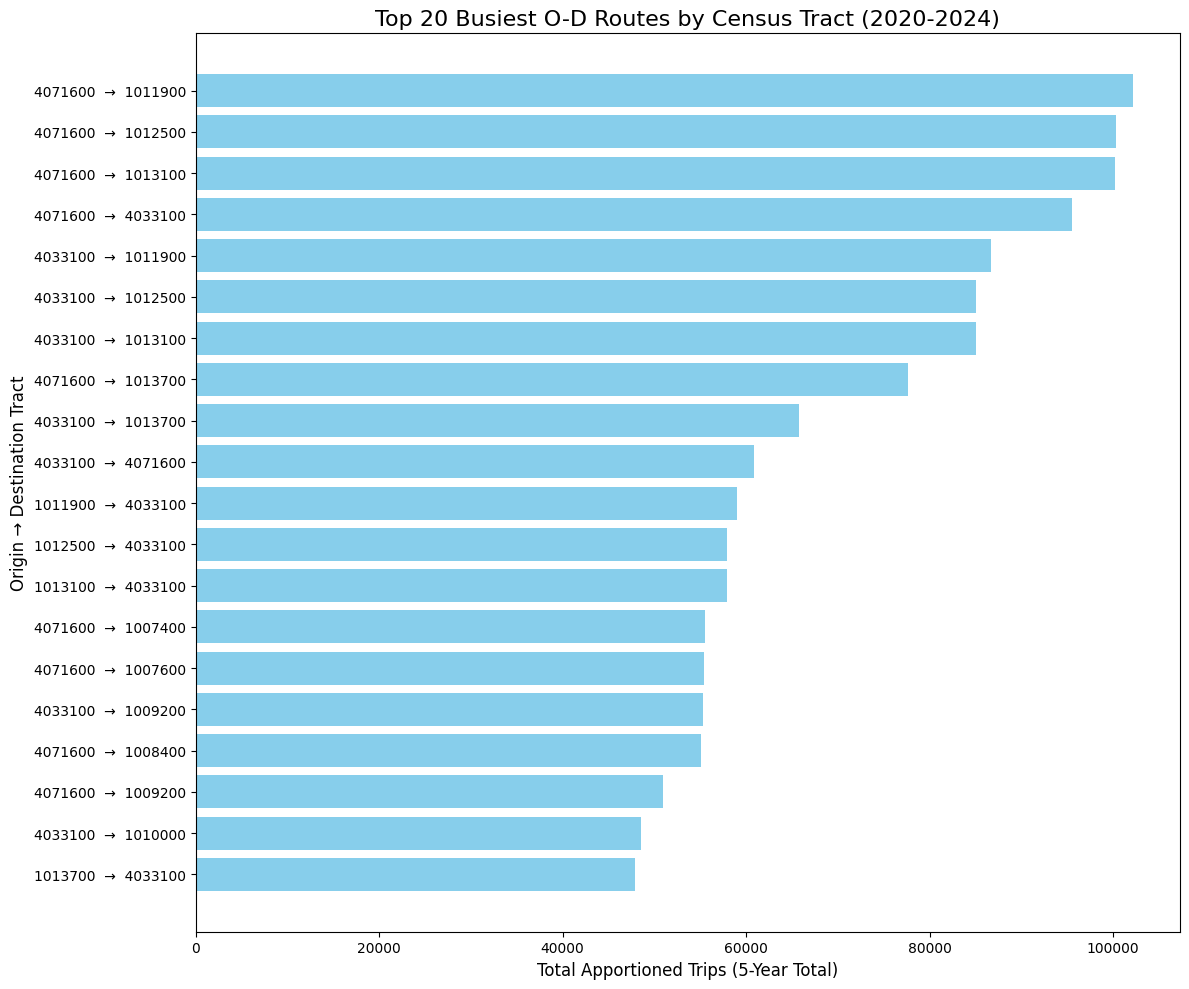


--- Top 10 Routes ---
                 route  total_trips
0  4071600  →  1011900  102169.8087
1  4071600  →  1012500  100254.4444
2  4071600  →  1013100  100208.7469
3  4071600  →  4033100   95493.7983
4  4033100  →  1011900   86679.2597
5  4033100  →  1012500   85054.2948
6  4033100  →  1013100   85015.5257
7  4071600  →  1013700   77589.2270
8  4033100  →  1013700   65726.9466
9  4033100  →  4071600   60904.1903


In [23]:
# --- 3. ANALYSIS 1: TOP 20 O-D ROUTES ---
TOP_N = 20

# Sort the entire DataFrame to find the 20 highest-demand routes
df_top_routes = df_od.sort_values(by='total_trips', ascending=False).head(TOP_N)

# Create a human-readable 'route' column for plotting
df_top_routes['route'] = df_top_routes['pickup_tract_id'].astype(str) + '  →  ' + df_top_routes['dropoff_tract_id'].astype(str)

# Sort ascending for the horizontal bar chart (so top item is on top)
df_top_routes.sort_values(by='total_trips', ascending=True, inplace=True)

# --- Plot ---
plt.figure(figsize=(12, 10))
plt.barh(df_top_routes['route'], df_top_routes['total_trips'], color='skyblue')
plt.title(f'Top {TOP_N} Busiest O-D Routes by Census Tract (2020-2024)', fontsize=16)
plt.xlabel('Total Apportioned Trips (5-Year Total)', fontsize=12)
plt.ylabel('Origin → Destination Tract', fontsize=12)
plt.tight_layout()
plt.show()

print("\n--- Top 10 Routes ---")
print(df_top_routes.sort_values(by='total_trips', ascending=False)[['route', 'total_trips']].head(10))